# DCBC model evaluation

In [1]:
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import os

In [2]:

def import_existing(cv=False):
    Data = pd.read_csv(
        f'{ut.model_dir}/Models/Evaluation/eval_all_5existing_on_taskDatasets.tsv', sep='\t')
    # Remove non-crossvalidated tests (where test_data == MDTB and train_data == MDTB10)
    if cv:
        for i, row in Data.iterrows():
            if row['test_data'] == 'MDTB' and row['train_data'] == 'MDTB10':
                Data.drop(i, inplace=True)
    Data['train_data_string'] = Data['train_data']
    
    return Data

In [3]:

def import_fusion(cv=False):
    # Import symmetric evaluation
    Sym = pd.read_csv(
        f'{ut.model_dir}/Models/Evaluation/eval_dataset7_sym.tsv', sep='\t')
    Sym['symmetry'] = 'Symmetric'
    Sym['train_data_string'] = Sym['train_data']
    Sym['train_data'] = Sym['train_data'].apply(lambda x: x.split("' '"))

    # Import asymmetric evaluation
    Asym = pd.read_csv(
        f'{ut.model_dir}/Models/Evaluation/eval_dataset7_asym-hem.tsv', sep='\t')
    Asym['symmetry'] = 'Asymmetric'

    # Remove non-crossvalidated tests
    Asym['train_data_string'] = Asym['train_data']
    Asym['train_data'] = Asym['train_data'].apply(lambda x: x.split("', '"))
    # Remove brackets and quotation marks from train_data
    for i, row in Asym.iterrows():
        for j, train_data in enumerate(row['train_data']):
            train_data = train_data.replace('[', '')
            train_data = train_data.replace(']', '')
            train_data = train_data.replace("'", '')
            Asym.at[i, 'train_data'][j] = train_data

    # Remove Asym entries with K=14 and K=28
    Asym = Asym[Asym['K'] != 14]
    Asym = Asym[Asym['K'] != 28]
    
    # Remove non-crossvalidated tests
    if cv:
        for i, row in Asym.iterrows():
            if row['test_data'] in row['train_data'] and not len(row['train_data']) == 7:
                Asym.drop(i, inplace=True)

    
    
    Data = pd.concat([Sym, Asym], axis=0)

    # Loop through rows and add indicator for those where train_data list is of length 6
    Data['train_data_len'] = Data['train_data'].apply(lambda x: len(x))
    # Make Training column 'Single' if train_data_len is 1, 'All' if train_data_len is 7 and 'Leave_one_out' if train_data_len is 6
    Data['Training'] = Data['train_data_len'].apply(
        lambda x: 'Single' if x == 1 else 'Leave_one_out')
    Data.loc[Data['train_data_len'] == 7, 'Training'] = 'All'
    Data.loc[Data['train_data_len'] == 6, 'train_data_string'] = 'Leave_one_out'
    Data.loc[Data['train_data_len'] == 7, 'train_data_string'] = 'All'

    # Drop K=100
    Data[Data['K'] != 100].groupby(
        ['symmetry', 'K', 'Training']).count()['test_data']


    Data[(Data['K'] == 10) & (Data['model_name'] == 'sym_MdPoIbWmDeSo')].groupby(
        ['symmetry', 'atlas', 'model_name', 'Training', 'test_data', 'common_kappa', 'model_type']).count()

    # Remove model_type 04 and K=100
    Data = Data[(Data['model_type'] == 'Models_03') & (Data['K'] != 100)]

    return Sym, Asym, Data


In [4]:

Existing = import_existing()
_, _, Fusion = import_fusion()

# # Get only leave_one_out
# Fusion = Fusion[Fusion['Training'] == 'Leave_one_out']


# Remove any entries from Fusion where train_data_string contains a bracket
Fusion = Fusion[~Fusion['train_data_string'].str.contains("'")]
    
# Average across subjects
Existing = Existing[['K', 'train_data_string', 'test_data', 'dcbc_group', 'model_type']].groupby(['K', 'train_data_string', 'test_data', 'model_type']).mean().reset_index()
Fusion = Fusion[['symmetry', 'K', 'train_data_string', 'test_data', 'dcbc_group', 'model_type']].groupby(['symmetry', 'K', 'train_data_string', 'test_data', 'model_type']).mean().reset_index()


Symmetric vs MDTB
TtestResult(statistic=-0.023661595434408374, pvalue=0.9812401875664326, df=40.0)
0.09477675848581982 0.09521206065922619
Symmetric vs Buckner17
TtestResult(statistic=0.22790267922589633, pvalue=0.8208828917107682, df=40.0)
0.09477675848581982 0.09067394101225064
Symmetric K68 vs MDTB10
TtestResult(statistic=0.4875129578623809, pvalue=0.6346796451871433, df=12.0)
0.10712682164901062 0.09521206065922619
Symmetric K34 vs MDTB10
TtestResult(statistic=0.3364714138807167, pvalue=0.742326331165041, df=12.0)
0.1034973015830679 0.09521206065922619
Symmetric K10 vs MDTB10
TtestResult(statistic=-0.8260213734452321, pvalue=0.4249106596032143, df=12.0)
0.07748305493462516 0.09521206065922619


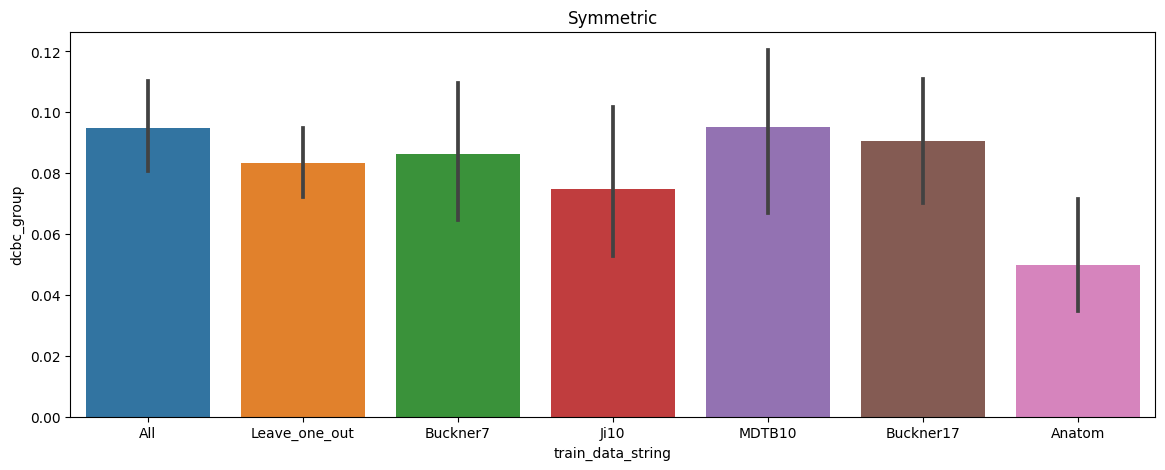

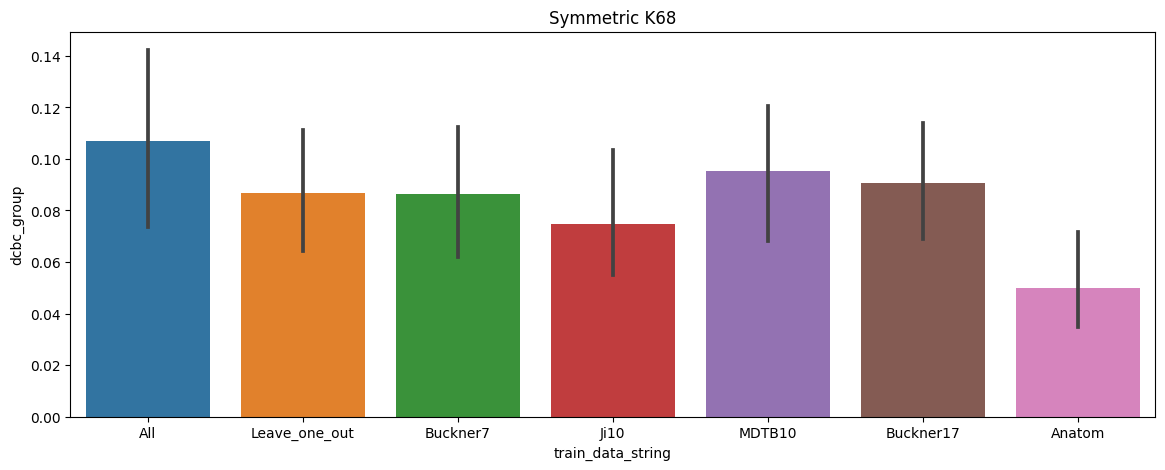

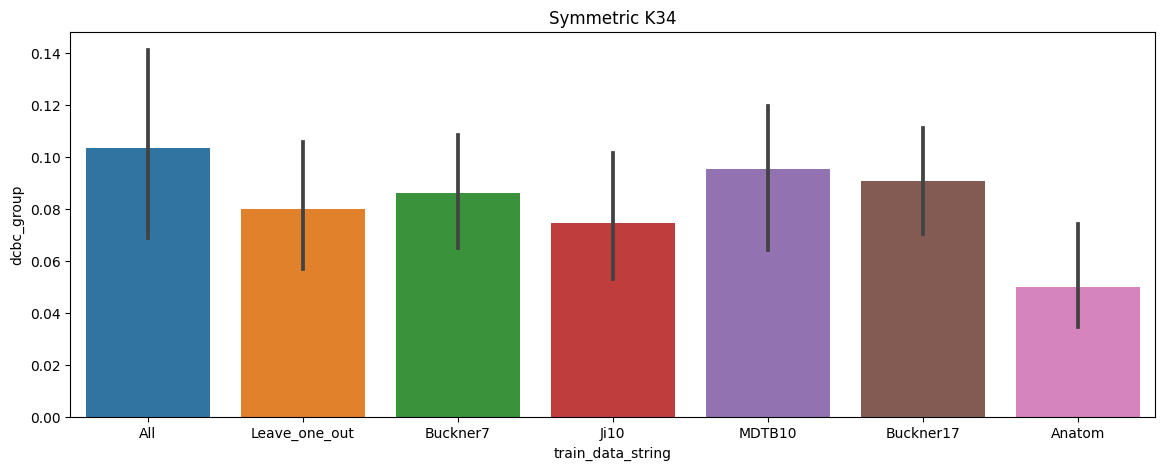

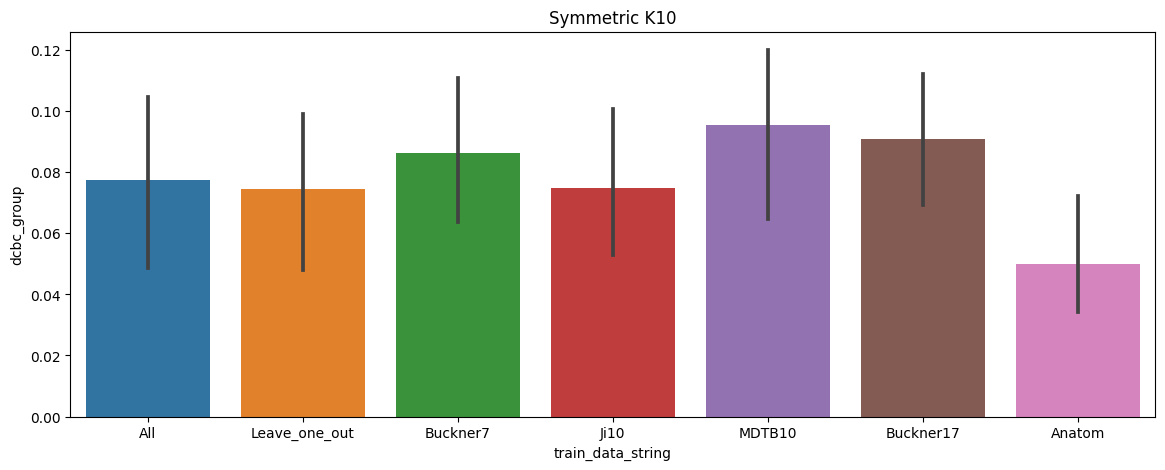

In [7]:
symmetry='Symmetric'
plot_data = Fusion[Fusion['symmetry'] == symmetry]
plot_data = pd.concat([plot_data, Existing], axis=0)


plt.figure(figsize=(14, 5))
sb.barplot(data=plot_data, x='train_data_string', y='dcbc_group')
# plt.savefig(f'{ut.figure_dir}/{symmetry}_vs_ex.png')
plt.title(f'{symmetry}')

print(f'{symmetry} vs MDTB')
x = plot_data[(plot_data['train_data_string'] == 'All')]['dcbc_group']
y = plot_data[(plot_data['train_data_string'] == 'MDTB10') ]['dcbc_group']
result = stats.ttest_ind(x, y)
print(result)                 
# print mean of x and y
print(np.mean(x), np.mean(y))

print(f'{symmetry} vs Buckner17')
x = plot_data[(plot_data['train_data_string'] == 'All')]['dcbc_group']
y = plot_data[(plot_data['train_data_string'] == 'Buckner17') ]['dcbc_group']
result = stats.ttest_ind(x, y)
print(result)
print(np.mean(x), np.mean(y))

# plt.figure()
# sb.barplot(data=plot_data, x='train_data_string', y='dcbc_group', hue='test_data')
# plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
# plt.savefig(f'{ut.figure_dir}/{symmetry}_vs_ex_testdata.png')

for K in [68, 34, 10]:
    plot_data = Fusion[Fusion['symmetry'] == symmetry]
    plot_data = pd.concat([plot_data[plot_data['K'] == K], Existing], axis=0)
    
    plt.figure(figsize=(14, 5))
    sb.barplot(data=plot_data, x='train_data_string', y='dcbc_group')
    # plt.savefig(f'{ut.figure_dir}/{symmetry}_vs_ex_K{K}.png')
    plt.title(f'{symmetry} K{K}')

    # plt.figure(figsize=(14, 5))
    # sb.barplot(data=plot_data, x='train_data_string', y='dcbc_group', hue='test_data')
    # plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    # plt.savefig(f'{ut.figure_dir}/{symmetry}_vs_ex_K{K}_testdata.png')

    x = plot_data[(plot_data['train_data_string'] == 'All')]['dcbc_group']
    y = plot_data[(plot_data['train_data_string'] == 'MDTB10')]['dcbc_group']
    print(f'{symmetry} K{K} vs MDTB10')
    result = stats.ttest_ind(x,y)
    print(result)
    print(np.mean(x), np.mean(y))

    # --- Show only MDTB as test_data ---
    # plt.figure()
    # sb.barplot(data=plot_data[plot_data['test_data'] == 'MDTB'], x='train_data_string', y='dcbc_group')
    # plt.savefig(f'{ut.figure_dir}/{symmetry}_vs_ex_K{K}_testdata_MDTB.png')

    # --- Test if Leave_one_out is significantly different from Buckner17 ---
    # print(f'{symmetry} K{K} Leave_one_out vs Buckner17')
    # result = stats.ttest_ind(plot_data[(plot_data['train_data_string'] == 'Leave_one_out') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'],
    #                       plot_data[(plot_data['train_data_string'] == 'Buckner17') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'])
    # print(result)

    # print(f'{symmetry} K{K} Leave_one_out vs Buckner17')
    # result = stats.ttest_ind(plot_data[(plot_data['train_data_string'] == 'Leave_one_out') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'],
    #                       plot_data[(plot_data['train_data_string'] == 'Buckner17') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'])
    # print(result)

    # stats.ttest_ind(plot_data[(plot_data['train_data_string'] == 'Leave_one_out') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'],
    #                       plot_data[(plot_data['train_data_string'] == 'Buckner7') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'])

    # stats.ttest_ind(plot_data[(plot_data['train_data_string'] == 'Leave_one_out') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'],
    #                       plot_data[(plot_data['train_data_string'] == 'Ji10') & (plot_data['test_data'] == 'MDTB')]['dcbc_group'])
    

    